In [1]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from decimal import Decimal
import odds_data_getter as odg


In [2]:
teams_df = pd.read_json('/Users/ccuulinay/github_proj/scrapy_proj/nba_odds_spider/lab/collection_backup/all_teams.json')

In [3]:
teams_df.drop(['TEAM_CITY', 'TEAM_NAME'],axis=1, inplace=True)

In [4]:
advanced_stat_df = pd.read_json('./advanced_data_slice_201702.json')

In [5]:
def read_n_preprocess_ah_df():
    ah_df = odg.read_mongo_data_to_dataframe()
    ah_df = ah_df[ah_df.away_team != 'Team USA']
    ah_df = ah_df[ah_df.away_team != 'West']
    ah_df = ah_df[ah_df.home_team != 'Team World']
    ah_df = ah_df[ah_df.away_team != 'EAST']
    
    ah_df = ah_df.merge(teams_df, how='left', left_on='away_team', right_on='FULL_TEAM_NAME')
    ah_df.drop(['FULL_TEAM_NAME'],axis=1, inplace=True)
    ah_df.rename(columns={'TEAM_ID': 'away_team_id'}, inplace=True)
    ah_df = ah_df.merge(teams_df, how='left', left_on='home_team', right_on='FULL_TEAM_NAME')
    ah_df.drop(['FULL_TEAM_NAME'],axis=1, inplace=True)
    ah_df.rename(columns={'TEAM_ID': 'home_team_id'}, inplace=True)
    
    ah_df['winner'] = np.where(ah_df['score_home'] - ah_df['score_away'] > 0, 'home', 'away')
    ah_df['ot'] = ah_df['overtime'].apply(lambda x: 1 if x == True else 0)
    ah_df['home_win'] = ah_df['winner'].apply(lambda x: 1 if x == 'home' else 0)

    ah_df['date_time_DT'] = pd.to_datetime(ah_df['date_time'])
    ah_df['year'] = ah_df['date_time_DT'].dt.year.astype(int)
    ah_df['month'] = ah_df['date_time_DT'].dt.month.astype(int)
    ah_df['day'] = ah_df['date_time_DT'].dt.day.astype(int)
    ah_df['weekDay'] = ah_df['date_time_DT'].dt.dayofweek.astype(int)

    for i in range(1, 5):
        ah_df["new_odd_home_" + str(i)] = ah_df["odd_home_" + str(i)].apply(lambda x: odg.to_decimal(x))
        ah_df["new_odd_away_" + str(i)] = ah_df["odd_away_" + str(i)].apply(lambda x: odg.to_decimal(x))
        ah_df["new_odd_home_" + str(i)] = ah_df["new_odd_home_" + str(i)].astype(float)
        ah_df["new_odd_away_" + str(i)] = ah_df["new_odd_away_" + str(i)].astype(float)

    ah_df.drop(
        ['odd_home_1', 'odd_home_2', 'odd_home_3', 'odd_home_4', 'odd_away_1', 'odd_away_2', 'odd_away_3',
         'odd_away_4'],
        axis=1, inplace=True)
    
    one_hot = pd.get_dummies(ah_df[['away_team', 'home_team']], prefix=['away_team_', 'home_team_'])
    ah_df = ah_df.join(one_hot)
    ah_df.drop(['away_team', 'home_team'], axis=1, inplace=True)
    ah_df.drop(['date_time', 'date_time_DT', 'winner', 'overtime'], axis=1, inplace=True)

    ah_df['total_score'] = ah_df['score_home'] + ah_df['score_away']
    ah_df['sub_score'] = ah_df['score_home'] - ah_df['score_away']
    
    # ah_df['bet_winner'] = np.where(float(row['sub_score']) + float(row['ah_'+str(num)]) >= 0, 'home', 'away')

    ah_df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
    return ah_df

In [6]:
ah_df = read_n_preprocess_ah_df()

In [7]:
COLUMNS = ['away_team__Atlanta_Hawks',
           'away_team__Boston_Celtics',
           'away_team__Brooklyn_Nets',
           'away_team__Charlotte_Hornets',
           'away_team__Chicago_Bulls',
           'away_team__Cleveland_Cavaliers',
           'away_team__Dallas_Mavericks',
           'away_team__Denver_Nuggets',
           'away_team__Detroit_Pistons',
           'away_team__Golden_State_Warriors',
           'away_team__Houston_Rockets',
           'away_team__Indiana_Pacers',
           'away_team__Los_Angeles_Clippers',
           'away_team__Los_Angeles_Lakers',
           'away_team__Memphis_Grizzlies',
           'away_team__Miami_Heat',
           'away_team__Milwaukee_Bucks',
           'away_team__Minnesota_Timberwolves',
           'away_team__New_Orleans_Pelicans',
           'away_team__New_York_Knicks',
           'away_team__Oklahoma_City_Thunder',
           'away_team__Orlando_Magic',
           'away_team__Philadelphia_76ers',
           'away_team__Phoenix_Suns',
           'away_team__Portland_Trail_Blazers',
           'away_team__Sacramento_Kings',
           'away_team__San_Antonio_Spurs',
           'away_team__Toronto_Raptors',
           'away_team__Utah_Jazz',
           'away_team__Washington_Wizards',
           'home_team__Atlanta_Hawks',
           'home_team__Boston_Celtics',
           'home_team__Brooklyn_Nets',
           'home_team__Charlotte_Hornets',
           'home_team__Chicago_Bulls',
           'home_team__Cleveland_Cavaliers',
           'home_team__Dallas_Mavericks',
           'home_team__Denver_Nuggets',
           'home_team__Detroit_Pistons',
           'home_team__Golden_State_Warriors',
           'home_team__Houston_Rockets',
           'home_team__Indiana_Pacers',
           'home_team__Los_Angeles_Clippers',
           'home_team__Los_Angeles_Lakers',
           'home_team__Memphis_Grizzlies',
           'home_team__Miami_Heat',
           'home_team__Milwaukee_Bucks',
           'home_team__Minnesota_Timberwolves',
           'home_team__New_Orleans_Pelicans',
           'home_team__New_York_Knicks',
           'home_team__Oklahoma_City_Thunder',
           'home_team__Orlando_Magic',
           'home_team__Philadelphia_76ers',
           'home_team__Phoenix_Suns',
           'home_team__Portland_Trail_Blazers',
           'home_team__Sacramento_Kings',
           'home_team__San_Antonio_Spurs',
           'home_team__Toronto_Raptors',
           'home_team__Utah_Jazz',
           'home_team__Washington_Wizards',
           'away_team_id',
           'home_team_id',
           'ah_1',
#            'odd_cnt_1',
           'new_odd_home_1',
           'new_odd_away_1',
#            'ah_2',
#            'odd_cnt_2',
#            'new_odd_home_2',
#            'new_odd_away_2',
#            'ah_3',
#            'odd_cnt_3',
#            'new_odd_home_3',
#            'new_odd_away_3',
#            'ah_4',
#            'odd_cnt_4',
#            'new_odd_home_4',
#            'new_odd_away_4',
           'year',
           'month',
           'day',
           'weekDay',
#            'ot',
           'home_win',
           'score_away',
           'score_home',
           'total_score',
           'sub_score']

FEATURES = COLUMNS[:-5]

In [8]:
ah_df = ah_df[COLUMNS]
home_win = ah_df['home_win']
sub_score = ah_df['sub_score']
ah_df.sort_values(by=['year', 'month','day'], ascending=[1, 1, 1], inplace=True)

In [9]:
ah_df.head()

,away_team__Atlanta_Hawks,away_team__Boston_Celtics,away_team__Brooklyn_Nets,away_team__Charlotte_Hornets,away_team__Chicago_Bulls,away_team__Cleveland_Cavaliers,away_team__Dallas_Mavericks,away_team__Denver_Nuggets,away_team__Detroit_Pistons,away_team__Golden_State_Warriors,...,new_odd_away_1,year,month,day,weekDay,home_win,score_away,score_home,total_score,sub_score
1185,0,0,0,0,0,0,0,0,0,0,...,1.89,2014,10,5,6,0,98,86,184,-12
1186,0,0,0,0,0,0,0,0,0,0,...,1.92,2014,10,6,0,1,94,99,193,5
1187,0,0,0,0,0,0,0,0,0,0,...,1.91,2014,10,7,1,1,78,98,176,20
1188,0,0,0,0,0,0,0,0,0,0,...,1.89,2014,10,7,1,1,87,93,180,6
1190,0,0,0,0,0,0,0,1,0,0,...,1.90,2014,10,7,1,1,95,98,193,3


In [10]:
result_df = pd.merge(advanced_stat_df, ah_df, left_index=True, right_index=True, how='inner')

In [11]:
COLUMNS = result_df.columns.tolist()
FEATURES = COLUMNS[:-5]

In [12]:
result_data = result_df.as_matrix()
result_data.shape

(3591, 152)

In [13]:
train_data = result_data[:,:-5]
train_label = result_data[:,-5:].astype(int)

In [73]:
from sklearn.ensemble import RandomForestRegressor
x_train, x_test, y_train, y_test = train_test_split(train_data,train_label[:,4], test_size=0.3)
# clf = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=4)

clf = Pipeline([
        ('ss', StandardScaler()),
        ('DTC', RandomForestRegressor(n_estimators=230, criterion='mse', max_depth=4))])
rf_clf = clf.fit(x_train, y_train)
y_hat = rf_clf.predict(x_test)

In [74]:
payout_df = pd.DataFrame(x_test, columns=FEATURES)
payout_df['predict_subscore'] = y_hat
payout_df['home_win'] = home_win
payout_df['sub_score'] = sub_score
# payout_df.head()
payout_df['payout_1'] = payout_df.apply(lambda x : odg.calculate_payout(x), axis=1)
# payout_df['payout_2'] = payout_df.apply(lambda x : calculate_payout(x, num=2), axis=1)
# payout_df['payout_3'] = payout_df.apply(lambda x : calculate_payout(x, num=3), axis=1)
# payout_df['payout_4'] = payout_df.apply(lambda x : calculate_payout(x, num=4), axis=1)
payout_df.payout_1.sum() # ,payout_df.payout_2.sum(),payout_df.payout_3.sum(),payout_df.payout_4.sum()

67.2936780787808

In [76]:
# Try XGBoost on subscore
import xgboost as xgb
x_train, x_test, y_train, y_test = train_test_split(train_data,train_label[:,4], test_size=0.3)

data_train = xgb.DMatrix(x_train, label=y_train)
data_test = xgb.DMatrix(x_test, label=y_test)
watch_list = [(data_test, 'eval'), (data_train, 'train')]
param = {'max_depth': 4, 'eta': 1, 'silent': 1, 'objective': 'reg:linear'}
bst = xgb.train(param, data_train, num_boost_round=6, evals=watch_list)
y_hat = bst.predict(data_test)

[0]	eval-rmse:11.7967	train-rmse:11.8842
[1]	eval-rmse:11.8487	train-rmse:11.6378
[2]	eval-rmse:12.0418	train-rmse:11.3708
[3]	eval-rmse:12.2141	train-rmse:11.1619
[4]	eval-rmse:12.2896	train-rmse:10.9777
[5]	eval-rmse:12.4301	train-rmse:10.736


In [77]:
payout_df = pd.DataFrame(x_test, columns=FEATURES)
payout_df['predict_subscore'] = y_hat
payout_df['home_win'] = home_win
payout_df['sub_score'] = sub_score
payout_df.head()
payout_df['payout_1'] = payout_df.apply(lambda x : odg.calculate_payout(x), axis=1)
#payout_df['payout_2'] = payout_df.apply(lambda x : calculate_payout(x, num=2), axis=1)
#payout_df['payout_3'] = payout_df.apply(lambda x : calculate_payout(x, num=3), axis=1)
#payout_df['payout_4'] = payout_df.apply(lambda x : calculate_payout(x, num=4), axis=1)
payout_df.payout_1.sum()#, payout_df.payout_2.sum(),payout_df.payout_3.sum(),payout_df.payout_4.sum()

-43.587036333128367

In [16]:
# Build a linear regressor for subscore
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV

x_train, x_test, y_train, y_test = train_test_split(train_data,train_label[:,4], test_size=0.3)

linreg = LinearRegression()
Lasreg = Lasso()
Ridreg = Ridge()
# lr_model = linreg.fit(x_train, y_train)
lr_model = Lasreg.fit(x_train, y_train)
# lr_model = Ridreg.fit(x_train, y_train)
# y_hat = linreg.predict(x_test)
y_hat = Lasreg.predict(x_test)
# y_hat = Ridreg.predict(x_test)

In [17]:
payout_df = pd.DataFrame(x_test, columns=FEATURES)
payout_df['predict_subscore'] = y_hat
payout_df['home_win'] = home_win
payout_df['sub_score'] = sub_score
payout_df.head()
payout_df['payout_1'] = payout_df.apply(lambda x : odg.calculate_payout(x), axis=1)
# payout_df['payout_2'] = payout_df.apply(lambda x : calculate_payout(x, num=2), axis=1)
# payout_df['payout_3'] = payout_df.apply(lambda x : calculate_payout(x, num=3), axis=1)
# payout_df['payout_4'] = payout_df.apply(lambda x : calculate_payout(x, num=4), axis=1)
payout_df.payout_1.sum()# , payout_df.payout_2.sum(),payout_df.payout_3.sum(),payout_df.payout_4.sum()

191.60938435070238

In [29]:
team_list = ['Atlanta_Hawks',
'Boston_Celtics',
'Brooklyn_Nets',
'Charlotte_Hornets',
'Chicago_Bulls',
'Cleveland_Cavaliers',
'Dallas_Mavericks',
'Denver_Nuggets',
'Detroit_Pistons',
'Golden_State_Warriors',
'Houston_Rockets',
'Indiana_Pacers',
'Los_Angeles_Clippers',
'Los_Angeles_Lakers',
'Memphis_Grizzlies',
'Miami_Heat',
'Milwaukee_Bucks',
'Minnesota_Timberwolves',
'New_Orleans_Pelicans',
'New_York_Knicks',
'Oklahoma_City_Thunder',
'Orlando_Magic',
'Philadelphia_76ers',
'Phoenix_Suns',
'Portland_Trail_Blazers',
'Sacramento_Kings',
'San_Antonio_Spurs',
'Toronto_Raptors',
'Utah_Jazz',
'Washington_Wizards']

In [62]:
away_payout = []
home_payout = []
for i in team_list:
    away_payout.append([i,payout_df[payout_df['away_team__'+i] == 1].payout_1.sum()])
    home_payout.append([i,payout_df[payout_df['home_team__'+i] == 1].payout_1.sum()])
# away_payout = np.array(away_payout)
# home_payout = np.array(home_payout)

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
sorted(away_payout, key=lambda x:x[1], reverse=True)

[['Philadelphia_76ers', 14.403893401585169],
 ['Memphis_Grizzlies', 14.095883361921096],
 ['Los_Angeles_Lakers', 13.966792452830186],
 ['Los_Angeles_Clippers', 12.139999999999997],
 ['Milwaukee_Bucks', 11.32540685832798],
 ['Portland_Trail_Blazers', 11.176714237172952],
 ['New_York_Knicks', 11.073362508035403],
 ['Cleveland_Cavaliers', 10.727856544327134],
 ['San_Antonio_Spurs', 10.627243107769422],
 ['New_Orleans_Pelicans', 10.021178893315305],
 ['Boston_Celtics', 8.4642971273159944],
 ['Brooklyn_Nets', 8.4073367045933391],
 ['Indiana_Pacers', 6.6190909090909091],
 ['Houston_Rockets', 6.2774012776081562],
 ['Denver_Nuggets', 5.3833962264150923],
 ['Detroit_Pistons', 5.3059259259259264],
 ['Orlando_Magic', 4.629999999999999],
 ['Oklahoma_City_Thunder', 4.3875692982799315],
 ['Utah_Jazz', 4.2092802939531904],
 ['Washington_Wizards', 4.1346784491533244],
 ['Golden_State_Warriors', 3.8199999999999985],
 ['Phoenix_Suns', 3.8100000000000005],
 ['Miami_Heat', 3.3199999999999976],
 ['Atlanta_

In [69]:
sorted(home_payout, key=lambda x:x[1], reverse=True)

[['Philadelphia_76ers', 19.968486040219787],
 ['Golden_State_Warriors', 17.804347252629277],
 ['New_York_Knicks', 13.907083186787421],
 ['Indiana_Pacers', 11.817315640334508],
 ['Sacramento_Kings', 11.219999999999999],
 ['Oklahoma_City_Thunder', 10.612555104919764],
 ['Cleveland_Cavaliers', 10.323396226415092],
 ['Washington_Wizards', 9.825925925925926],
 ['Los_Angeles_Clippers', 8.4259259259259238],
 ['Charlotte_Hornets', 8.3633962264150945],
 ['Chicago_Bulls', 7.8704089778724935],
 ['Phoenix_Suns', 7.2236454541041688],
 ['Minnesota_Timberwolves', 6.4999999999999991],
 ['Milwaukee_Bucks', 6.4399999999999986],
 ['Memphis_Grizzlies', 6.3428218383558175],
 ['Houston_Rockets', 6.3099999999999978],
 ['Atlanta_Hawks', 5.3583251282611828],
 ['New_Orleans_Pelicans', 5.3569603916332866],
 ['San_Antonio_Spurs', 5.2650168350168354],
 ['Dallas_Mavericks', 5.0233962264150946],
 ['Detroit_Pistons', 4.9188573438057457],
 ['Portland_Trail_Blazers', 4.4242971273159943],
 ['Brooklyn_Nets', 2.7432818532

# Plot the payout from each team of home and road game
Model perform the best on 76ers. Most like because 76ers has been so bad during last three years and easy to predict (It will lost the game and the bet!!!). And seem my model play better on road game than home game.

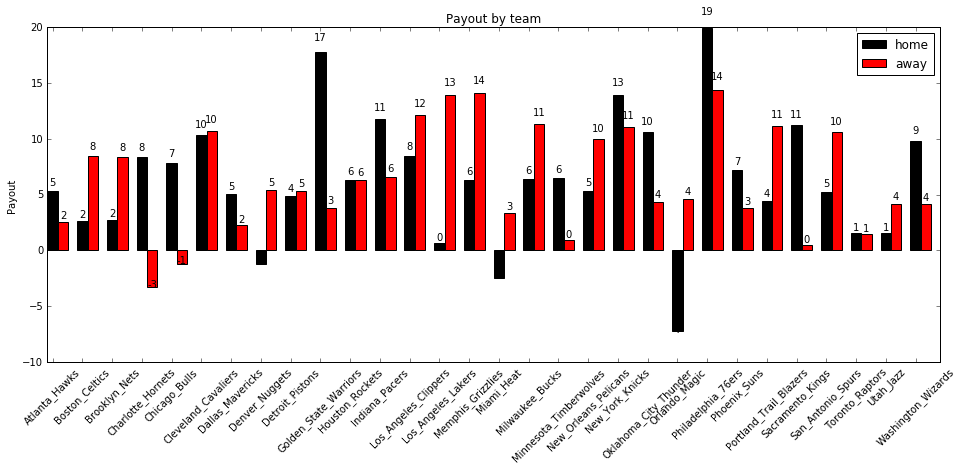

In [87]:
fig = plt.figure(figsize=(16,6),dpi=80)
ax = fig.add_subplot(111)
N = 30

ind = np.arange(N)
width = 0.35

rects1 = ax.bar(ind, np.array(home_payout)[:,1], width,
                color='black')

rects2 = ax.bar(ind+width, np.array(away_payout)[:,1], width,
                color='red')

ax.set_ylabel('Payout')
ax.set_title('Payout by team')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((x for x in np.array(home_payout)[:,0]), rotation=45)


ax.legend((rects1[0], rects2[0]), ('home', 'away'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()